# Introduction

- Objective: Forecast household energy consumption using ARIMA, Prophet, and XGBoost.
- We will perform data preprocessing, EDA, feature engineering, and model comparisons.
- Dataset: household_power_consumption.csv

# Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Load Dataset

In [12]:
df = pd.read_csv("household_power_consumption.csv", sep=",", na_values="?")

# Combine Date + Time into one datetime column
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")

# Set as index
df = df.set_index("Datetime")

print(df.head())
print(df.info())

                           Date      Time  Global_active_power  \
Datetime                                                         
2006-12-16 17:24:00  16/12/2006  17:24:00                4.216   
2006-12-16 17:25:00  16/12/2006  17:25:00                5.360   
2006-12-16 17:26:00  16/12/2006  17:26:00                5.374   
2006-12-16 17:27:00  16/12/2006  17:27:00                5.388   
2006-12-16 17:28:00  16/12/2006  17:28:00                3.666   

                     Global_reactive_power  Voltage  Global_intensity  \
Datetime                                                                
2006-12-16 17:24:00                  0.418   234.84              18.4   
2006-12-16 17:25:00                  0.436   233.63              23.0   
2006-12-16 17:26:00                  0.498   233.29              23.0   
2006-12-16 17:27:00                  0.502   233.74              23.0   
2006-12-16 17:28:00                  0.528   235.68              15.8   

                     Sub_

# Handle Missing Values

In [13]:
df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(method='ffill')   

# Resample

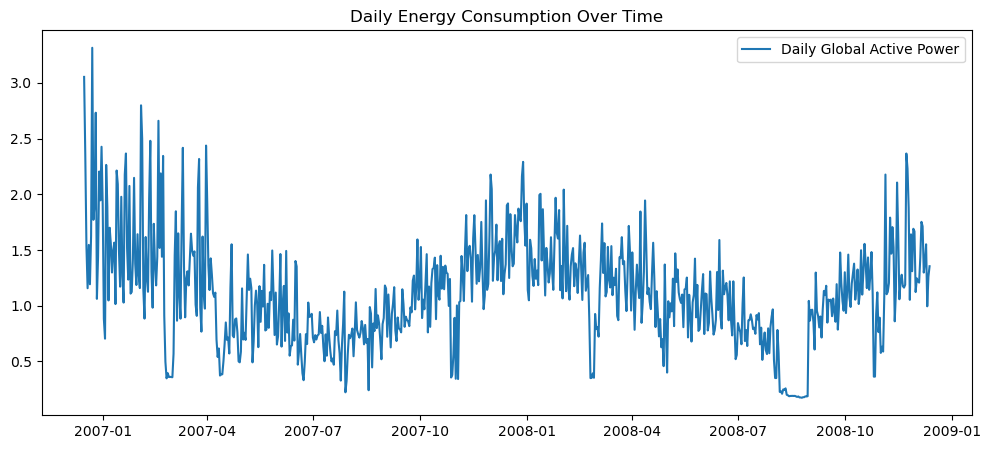

In [14]:
daily = df['Global_active_power'].resample('D').mean()
plt.figure(figsize=(12,5))
plt.plot(daily, label="Daily Global Active Power")
plt.legend()
plt.title("Daily Energy Consumption Over Time")
plt.show()

# Feature Engineering

In [15]:
daily_df = daily.reset_index()
daily_df['day'] = daily_df['Datetime'].dt.day
daily_df['month'] = daily_df['Datetime'].dt.month
daily_df['year'] = daily_df['Datetime'].dt.year
daily_df['dayofweek'] = daily_df['Datetime'].dt.dayofweek

# Train-Test Split

In [16]:
train_size = int(len(daily) * 0.8)
train, test = daily[:train_size], daily[train_size:]

## Model 1: ARIMA

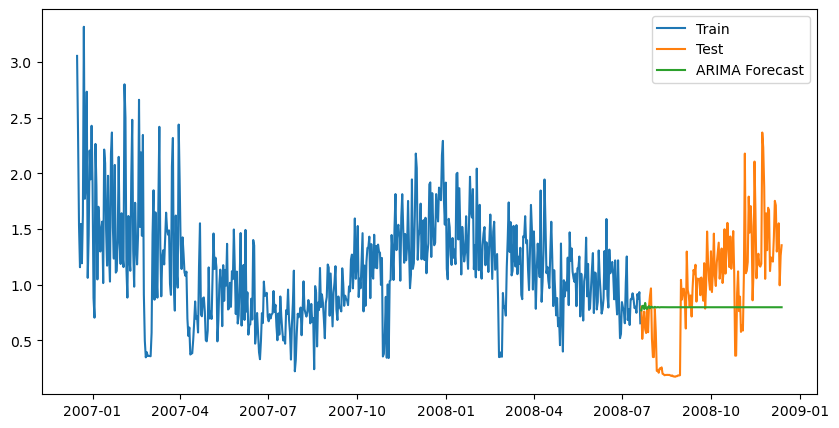

ARIMA MAE: 0.42999745148214924
ARIMA RMSE: 0.5190413970333211


In [17]:
arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))

plt.figure(figsize=(10,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(test.index, arima_pred, label="ARIMA Forecast")
plt.legend()
plt.show()

print("ARIMA MAE:", mean_absolute_error(test, arima_pred))
print("ARIMA RMSE:", np.sqrt(mean_squared_error(test, arima_pred)))

## Model 2: Prophet

02:16:28 - cmdstanpy - INFO - Chain [1] start processing
02:16:29 - cmdstanpy - INFO - Chain [1] done processing


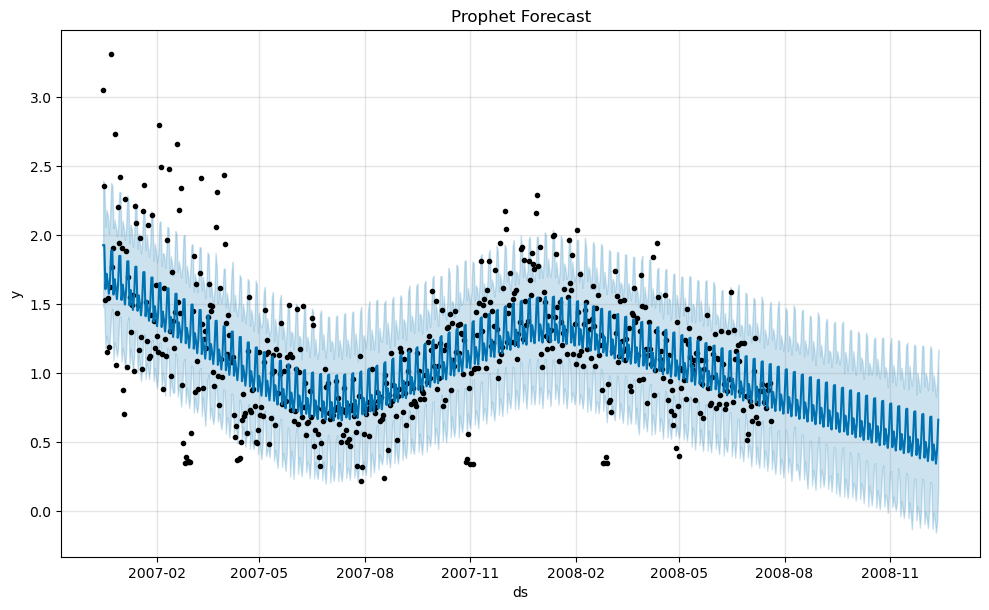

In [18]:
prophet_df = daily.reset_index()
prophet_df.columns = ['ds','y']

train_p = prophet_df.iloc[:train_size]
test_p = prophet_df.iloc[train_size:]

prophet_model = Prophet()
prophet_model.fit(train_p)

future = prophet_model.make_future_dataframe(periods=len(test_p))
forecast = prophet_model.predict(future)

prophet_model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

## Model 3: XGBoost

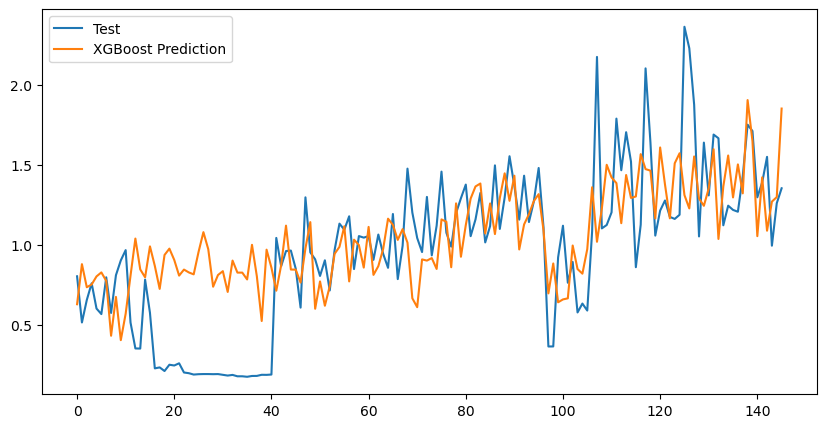

XGBoost MAE: 0.3160430070989225
XGBoost RMSE: 0.4011131624579889


In [19]:
X = daily_df.drop(['Datetime','Global_active_power'], axis=1)
y = daily_df['Global_active_power']

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Test")
plt.plot(y_pred, label="XGBoost Prediction")
plt.legend()
plt.show()

print("XGBoost MAE:", mean_absolute_error(y_test, y_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Conclusion

- ARIMA provides a baseline but may struggle with seasonality.
- Prophet captures trends and seasonality more effectively.
- XGBoost with engineered features can provide strong predictive performance.